In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import random
sys.path.append(os.path.abspath("../"))

# KMP_DUPLICATE_LIB_OK=TRUE
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
from omegaconf import OmegaConf
from hydra import initialize, compose
from src.data_loading_well import load_data_by_well

# Path to your Hydra config directory
config_path = "../configs"       # Adjust as needed
config_name = "config"        # Name of your YAML file without .yaml

# Load the config
with initialize(version_base=None, config_path=config_path):
    cfg = compose(config_name=config_name)
print(OmegaConf.to_yaml(cfg))

project:
  name: VAE_BBBC021
model:
  name: VAEMedium
  input_channels: 3
  latent_dim: 256
data:
  train_path: data/raw/BBBC021_dataset_cleaned_maxnorm_68.h5
  metadata_path: data/raw/metadata_dataset.h5
  crop_pixels: 0
  train_ratio: 0.8
  val_ratio: 0.1
  test_ratio: 0.1
train:
  batch_size: 256
  epochs: 200
  learning_rate: 0.001
  discriminator_lr: 0.01



In [5]:
# Path to the cleaned + preprocessed dataset
h5_path = '../data/raw/BBBC021_dataset.h5'

with h5py.File(h5_path, 'r') as h5f:
    images = h5f['images']
    names = h5f['image_names']

    num_images = images.shape[0]
    img_shape = images.shape[1:]
    dtype = images.dtype

    print(f"Dataset loaded from: {h5_path}")
    print(f"Number of images: {num_images}")
    print(f"Image shape: {img_shape}")
    print(f"Data type: {dtype}")
    print(f"Sample names: {[names[i].decode('utf-8') for i in range(min(5, num_images))]}")

Dataset loaded from: ../data/raw/BBBC021_dataset.h5
Number of images: 488396
Image shape: (68, 68, 3)
Data type: uint16
Sample names: ['B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_0.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_1.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_10.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_100.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_101.npy']


In [6]:
def get_random_image(num_samples=10000, seed=0):
    h5_path = '../data/raw/BBBC021_dataset.h5'
    with h5py.File(h5_path, 'r') as h5f:
        images = h5f['images']
        random.seed(seed)
        num_samples = num_samples
        indices = random.sample(range(images.shape[0]), num_samples)
        sorted_indices = sorted(indices)
        sampled_images = images[sorted_indices]
    return sampled_images

In [7]:
import numpy as np
import random
from matplotlib.ticker import ScalarFormatter

# take max norm of all images
def max_normalize_image(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    max_vals = image.max(axis=(0, 1), keepdims=True)  # shape (1, 1, C)
    max_vals = np.maximum(max_vals, 1e-5)  # prevent division by 0
    return image / max_vals

def plot_pixel_value_distribution_orig_vs_normalized(images: np.ndarray, num_samples: int = 1000):
    # Set up 2×3 grid
    channel_labels = ['Red', 'Green', 'Blue']
    colors = ['r', 'g', 'b']

    # Biological meaning
    labels = ["Actin", "Tubulin", "DAPI"]  # R, G, B

    normalized_images = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        normalized_images[i] = max_normalize_image(images[i])

    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 0))  # always use scientific notation
    for c in range(3):
        axs[0, c].hist(images[:, :, :, c].ravel(), bins=50, color=colors[c], alpha=0.7, density=True, label=labels[c])
        axs[0, c].set_title(f"Original - {channel_labels[c]}")
        axs[0, c].set_xlabel("Pixel Intensity")
        axs[0, c].set_ylabel("Frequency")
        axs[0, c].set_xlim(0, 65535)  # 16-bit TIFF images
        axs[0, c].legend()
        axs[0, c].yaxis.set_major_formatter(formatter)

        axs[1, c].hist(normalized_images[:, :, :, c].ravel(), bins=50, color=colors[c], alpha=0.7, density=True, label=labels[c])
        axs[1, c].set_title(f"Max-Norm - {channel_labels[c]}")
        axs[1, c].set_xlabel("Normalized Intensity")
        axs[1, c].set_ylabel("Frequency")
        axs[1, c].legend()

    plt.tight_layout()
    plt.suptitle("BBBC021 - Channel Intensity Distributions (sample of 10000 images)", y=1.03, fontsize=16)
    plt.show()

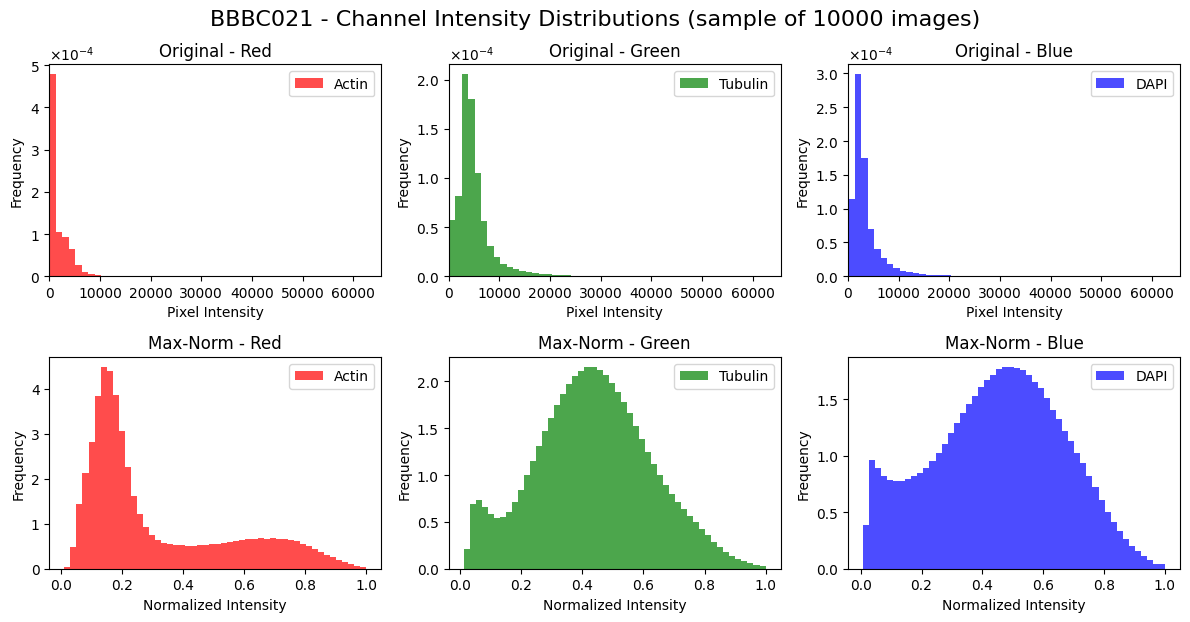

In [8]:
plot_pixel_value_distribution_orig_vs_normalized(get_random_image(10000))

In [22]:
from src.data_loading_well import load_data_by_well, load_metadata

# Load all data and metadata
cfg.data.metadata_path = '../data/raw/metadata_dataset.h5'
cfg.data.train_path = '../data/raw/BBBC021_dataset_cleaned_maxnorm_68.h5'
data_loader = load_data_by_well(cfg, split="all")

# Extract values
num_images = len(data_loader.dataset)
image_shape = next(iter(data_loader))[0][0].shape  # (C, H, W)

KeyError: 'all'

In [11]:
train_loader = load_data_by_well(cfg, split="train")
val_loader = load_data_by_well(cfg, split="val")
test_loader = load_data_by_well(cfg, split="test")

Loading train split
Loaded 480763 wells from ../data/raw/BBBC021_dataset_cleaned_maxnorm_68.h5
Splitting wells: train 769 (79.94%), val 96 (9.98%), test 97 (10.08%)
Size of splits: train 382145 (79.49%), val 53263 (11.08%), test 45355 (9.43%)
Loading val split
Loaded 480763 wells from ../data/raw/BBBC021_dataset_cleaned_maxnorm_68.h5
Splitting wells: train 769 (79.94%), val 96 (9.98%), test 97 (10.08%)
Size of splits: train 382145 (79.49%), val 53263 (11.08%), test 45355 (9.43%)
Loading test split
Loaded 480763 wells from ../data/raw/BBBC021_dataset_cleaned_maxnorm_68.h5
Splitting wells: train 769 (79.94%), val 96 (9.98%), test 97 (10.08%)
Size of splits: train 382145 (79.49%), val 53263 (11.08%), test 45355 (9.43%)


In [23]:
cfg.data.metadata_path = "../data/raw/metadata_dataset.h5"
with h5py.File(cfg.data.metadata_path, 'r') as f:
    wells = f["metadata_well"][:].astype(str)
    compounds = f["metadata_compound"][:].astype(str)
    concentrations = f["metadata_concentration"][:].astype(str)
    moas = f["metadata_moa"][:].astype(str)

meta_df = pd.DataFrame({
    "well": wells,
    "compound": compounds,
    "concentration": concentrations,
    "moa": moas
})

In [ ]:
summary = {
    "Total images": [num_images],
    "Wells": [len(set(wells))],
    "Compounds": [len(set(compounds))],
    "MoAs": [len(set(moas))],
    "Image size": [f"{image_shape[1]}×{image_shape[2]}×{image_shape[0]}"],
}

summary_df = pd.DataFrame(summary).T
summary_df.columns = ["Value"]
summary_df

NameError: name 'num_images' is not defined

In [14]:
# Use the subset that we get from the different loaders to index the metadata
meta_df_train = meta_df.iloc[train_loader.dataset.indices]
meta_df_val = meta_df.iloc[val_loader.dataset.indices]
meta_df_test = meta_df.iloc[test_loader.dataset.indices]

In [16]:
# Print Number of unique wells, compounds, concentrations, and MoAs in each split
def print_unique_counts(df, split_name):
    print(f"\n{split_name} Split:")
    print(f"Unique Wells: {df['well'].nunique()}")
    print(f"Unique Compounds: {df['compound'].nunique()}")
    print(f"Unique Concentrations: {df['concentration'].nunique()}")
    print(f"Unique MoAs: {df['moa'].nunique()}")
    
print_unique_counts(meta_df_train, "Train")
print_unique_counts(meta_df_val, "Validation")
print_unique_counts(meta_df_test, "Test")


Train Split:
Unique Wells: 769
Unique Compounds: 39
Unique Concentrations: 19
Unique MoAs: 13

Validation Split:
Unique Wells: 96
Unique Compounds: 21
Unique Concentrations: 13
Unique MoAs: 13

Test Split:
Unique Wells: 97
Unique Compounds: 18
Unique Concentrations: 10
Unique MoAs: 10


In [25]:
def wells_per_moa(meta_df):
    wells_per_moa = meta_df.groupby('moa')['well'].nunique().reset_index()
    wells_per_moa.columns = ['MoA', 'Unique Wells']
    wells_per_moa = wells_per_moa.sort_values(by='Unique Wells', ascending=False)
    return wells_per_moa

wells_per_moa_all = wells_per_moa(meta_df)
wells_per_moa_all

MoA  Unique Wells
10    Microtubule stabilizers           357
3                        DMSO           330
9   Microtubule destabilizers            42
1    Aurora kinase inhibitors            36
6              Eg5 inhibitors            36
4                  DNA damage            27
5             DNA replication            24
12          Protein synthesis            24
7                  Epithelial            22
11        Protein degradation            21
2        Cholesterol-lowering            18
0            Actin disruptors            15
8           Kinase inhibitors            10

In [ ]:
# What is well count per compound sorted by number of wells?
def wells_per_compound(meta_df):
    wells_per_compound = meta_df.groupby('compound')['well'].nunique().reset_index()
    wells_per_compound.columns = ['Compound', 'Unique Wells']
    wells_per_compound = wells_per_compound.sort_values(by='Unique Wells', ascending=False)
    return wells_per_compound

wells_per_compound_all = wells_per_compound(meta_df)
wells_per_compound_all

Compound  Unique Wells
37                   taxol           339
8                     DMSO           330
2                     AZ-C            21
38             vincristine            21
1                     AZ-A            18
5                    AZ138            15
22             demecolcine            12
32             mitomycin C            12
6                    AZ258             9
3                     AZ-J             9
4                     AZ-U             9
26               etoposide             9
19           cyclohexamide             9
15            camptothecin             9
7                    AZ841             9
23               docetaxel             9
25            epothilone B             9
24                 emetine             9
31    mevinolin/lovastatin             9
36             simvastatin             9
0                     ALLN             6
9                   MG-132             6
20          cytochalasin B             6
13              anisomycin             6
33            mitoxantrone             6
29           latrunculin B             6
27             floxuridine             6
34              nocodazole             6
35  proteasome inhibitor I             6
12          alsterpaullone             4
11                    PP-2             4
10               PD-169316             4
18              colchicine             3
17               cisplatin             3
16            chlorambucil             3
30            methotrexate             3
21          cytochalasin D             3
28             lactacystin             3
14              bryostatin             2

In [17]:
# What MOAs are missing in the test set?
missing_moas = set(meta_df['moa']) - set(meta_df_test['moa'])
print(f"\nMissing MoAs in Test Set: {missing_moas}")


Missing MoAs in Test Set: {'Microtubule destabilizers', 'Cholesterol-lowering', 'Actin disruptors'}


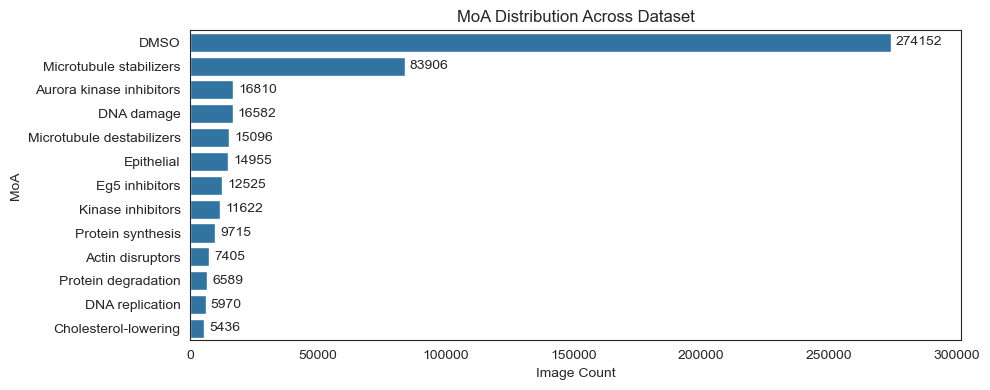

In [14]:
# count frequencies
moa_counts = pd.Series(meta_df["moa"]).value_counts().reset_index()
moa_counts.columns = ["MoA", "Image Count"]

# optional: plot
plt.figure(figsize=(10, 4))
sns.barplot(data=moa_counts, y="MoA", x="Image Count")
# show counts on bars
for index, value in enumerate(moa_counts["Image Count"]):
    plt.text(value + 2000, index, str(value), va='center')
plt.title("MoA Distribution Across Dataset")
plt.xlim(0, moa_counts["Image Count"].max() * 1.1)
plt.tight_layout()
plt.show()

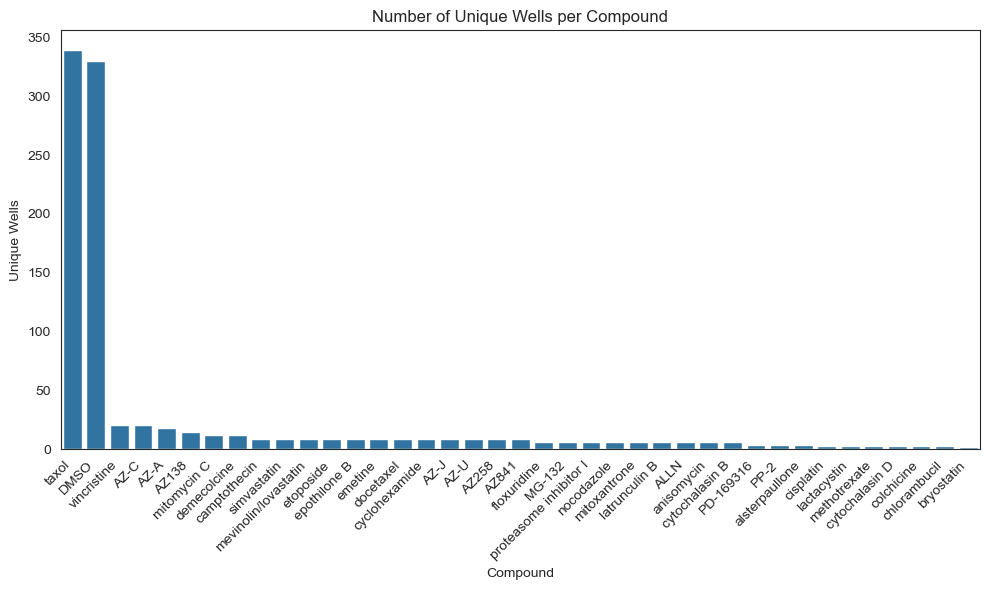

In [15]:
# Show well per compound
compound_well_counts = meta_df.groupby("compound")["well"].nunique().reset_index()
compound_well_counts.columns = ["Compound", "Unique Wells"]

plt.figure(figsize=(10, 6))
sorted_compounds = compound_well_counts.sort_values(by="Unique Wells", ascending=False)
sns.barplot(data=sorted_compounds, y="Unique Wells", x="Compound")
plt.xticks(rotation=45, ha='right')
plt.title("Number of Unique Wells per Compound")
plt.tight_layout()
plt.show()

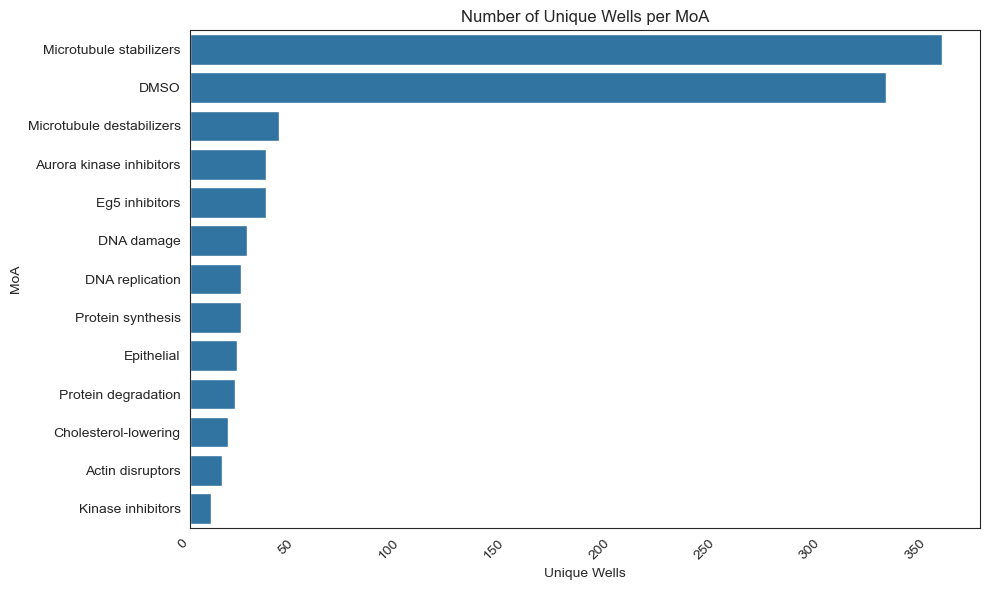

In [16]:
# Well per MoA
# number of unique wells per MoA
well_moa_counts = meta_df.groupby("moa")["well"].nunique().reset_index()
well_moa_counts.columns = ["MoA", "Unique Wells"]
plt.figure(figsize=(10, 6))
sorted_well_moa = well_moa_counts.sort_values(by="Unique Wells", ascending=False)
sns.barplot(data=sorted_well_moa, y="MoA", x="Unique Wells")
plt.xticks(rotation=45, ha='right')
plt.title("Number of Unique Wells per MoA")
plt.tight_layout()
plt.show()

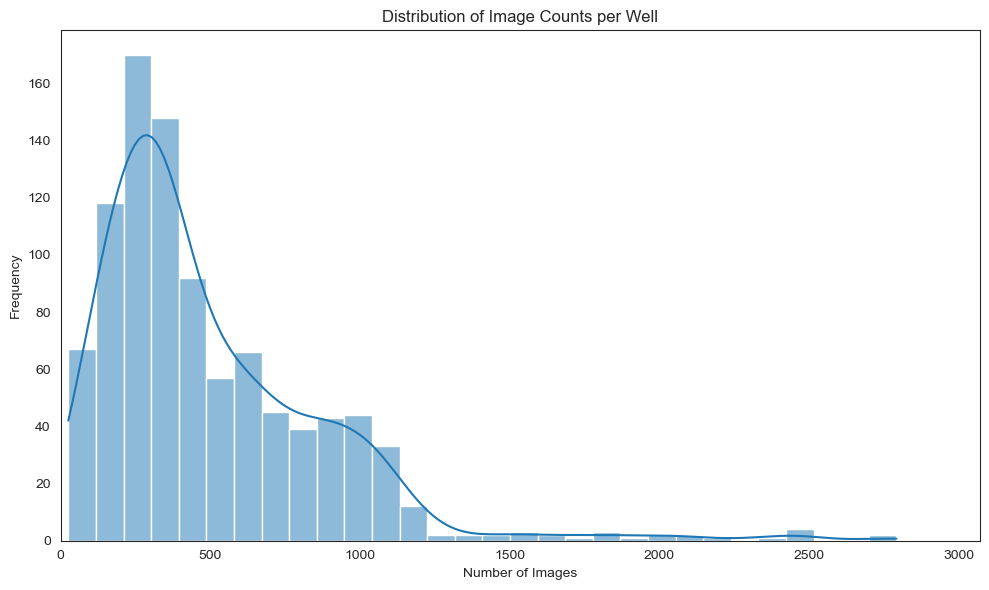

In [17]:
# Image count per well
well_image_counts = meta_df.groupby("well")["compound"].count().reset_index()
well_image_counts.columns = ["Well", "Image Count"]
plt.figure(figsize=(10, 6))
sns.histplot(well_image_counts["Image Count"], bins=30, kde=True)
plt.title("Distribution of Image Counts per Well")
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.xlim(0, well_image_counts["Image Count"].max() * 1.1)
plt.tight_layout()
plt.show()

In [18]:
# Give me a table with the number of images per compound
compound_image_counts = meta_df.groupby("compound")["well"].count().reset_index()
compound_image_counts.columns = ["Compound", "Image Count"]
compound_image_counts.T

0     1     2     3     4      5      6      7       8   \
Compound     ALLN  AZ-A  AZ-C  AZ-J  AZ-U  AZ138  AZ258  AZ841    DMSO   
Image Count  1708  7322  6440  6165  7239   6085   3995   5493  274152   

                 9   ...             29            30                    31  \
Compound     MG-132  ...  latrunculin B  methotrexate  mevinolin/lovastatin   
Image Count    1042  ...           4043          1083                  2838   

                      32            33          34                      35  \
Compound     mitomycin C  mitoxantrone  nocodazole  proteasome inhibitor I   
Image Count         7205          1458        1456                    2576   

                      36     37           38  
Compound     simvastatin  taxol  vincristine  
Image Count         2598  78060         6722  

[2 rows x 39 columns]

In [30]:
# Table with the number of images per MoA
moa_image_counts = meta_df.groupby("moa")["well"].count().reset_index()
moa_image_counts.columns = ["MoA", "Image Count"]
moa_image_counts['Well Count'] = meta_df.groupby("moa")["well"].nunique().values
moa_image_counts["Compound Count"] = meta_df.groupby("moa")["compound"].nunique().values
# sort by image count
moa_image_counts = moa_image_counts.sort_values(by="Image Count", ascending=False)
moa_image_counts

MoA  Image Count  Well Count  Compound Count
3                        DMSO       274152         330               1
10    Microtubule stabilizers        83906         357               3
1    Aurora kinase inhibitors        16810          36               3
4                  DNA damage        16582          27               4
9   Microtubule destabilizers        15096          42               4
7                  Epithelial        14955          22               3
6              Eg5 inhibitors        12525          36               2
8           Kinase inhibitors        11622          10               3
12          Protein synthesis         9715          24               3
0            Actin disruptors         7405          15               3
11        Protein degradation         6589          21               4
5             DNA replication         5970          24               4
2        Cholesterol-lowering         5436          18               2

In [34]:
pd.set_option('display.max_colwidth', None)
moa_image_counts = meta_df.groupby('moa')['well'].count().reset_index()
moa_image_counts.columns = ['MoA', 'Image Count']
moa_image_counts['Well Count'] = meta_df.groupby('moa')['well'].nunique().values
moa_image_counts['Compound Count'] = meta_df.groupby('moa')['compound'].nunique().values
moa_image_counts = moa_image_counts.sort_values(by='Well Count', ascending=False)
comp_counts = meta_df.groupby(['moa', 'compound'])['well'].nunique().reset_index(name='wells_per_compound')
comp_counts['entry'] = comp_counts['compound'] + ' (' + comp_counts['wells_per_compound'].astype(str) + ')'
comp_list = comp_counts.groupby('moa')['entry'].apply(lambda x: ', '.join(x)).reset_index(name='Compounds (wells)')
moa_image_counts = moa_image_counts.merge(comp_list, left_on='MoA', right_on='moa').drop(columns=['moa'])
moa_image_counts

MoA  Image Count  Well Count  Compound Count  \
0     Microtubule stabilizers        83906         357               3   
1                        DMSO       274152         330               1   
2   Microtubule destabilizers        15096          42               4   
3    Aurora kinase inhibitors        16810          36               3   
4              Eg5 inhibitors        12525          36               2   
5                  DNA damage        16582          27               4   
6             DNA replication         5970          24               4   
7           Protein synthesis         9715          24               3   
8                  Epithelial        14955          22               3   
9         Protein degradation         6589          21               4   
10       Cholesterol-lowering         5436          18               2   
11           Actin disruptors         7405          15               3   
12          Kinase inhibitors        11622          10               3   

                                                        Compounds (wells)  
0                            docetaxel (9), epothilone B (9), taxol (339)  
1                                                              DMSO (330)  
2      colchicine (3), demecolcine (12), nocodazole (6), vincristine (21)  
3                                         AZ-A (18), AZ258 (9), AZ841 (9)  
4                                                   AZ-C (21), AZ138 (15)  
5        chlorambucil (3), cisplatin (3), etoposide (9), mitomycin C (12)  
6   camptothecin (9), floxuridine (6), methotrexate (3), mitoxantrone (6)  
7                          anisomycin (6), cyclohexamide (9), emetine (9)  
8                                            AZ-J (9), AZ-U (9), PP-2 (4)  
9       ALLN (6), MG-132 (6), lactacystin (3), proteasome inhibitor I (6)  
10                              mevinolin/lovastatin (9), simvastatin (9)  
11              cytochalasin B (6), cytochalasin D (3), latrunculin B (6)  
12                      PD-169316 (4), alsterpaullone (4), bryostatin (2)

In [153]:
import random
from collections import defaultdict
import h5py

# Load metadata
cfg.data.metadata_path = '../data/raw/metadata_dataset.h5'
with h5py.File(cfg.data.metadata_path, 'r') as f:
    wells_meta     = [w.decode('utf-8') for w in f['metadata_well'][:]]
    compounds_meta = [c.decode('utf-8') for c in f['metadata_compound'][:]]
    concentrations_meta = [c.decode('utf-8') for c in f['metadata_concentration'][:]]
    moas_meta      = [m.decode('utf-8') for m in f['metadata_moa'][:]]

# Build mapping: compound-concentration → unique set of wells
compound_to_wells = defaultdict(set)

for well, compound in zip(wells_meta, compounds_meta):
    compound_to_wells[compound].add(well)

# Convert sets to sorted lists (for deterministic order)
compound_to_wells = {k: list(v) for k, v in compound_to_wells.items()}

# Check total and targets
total_wells = sum(len(wells) for wells in compound_to_wells.values())
val_target  = int(round(cfg.data.val_ratio  * total_wells))
test_target = int(round(cfg.data.test_ratio * total_wells))

print(f"Total wells (unique per compound-conc): {total_wells}, Validation target: {val_target}, Test target: {test_target}")

Total wells (unique per compound-conc): 962, Validation target: 96, Test target: 96


In [16]:
len(compound_to_wells.items())

39

In [123]:
# make a mutable copy of each compound’s wells
comp_wells = {c: list(wells) for c, wells in compound_to_wells.items()}

# initialize split‐storage and counters
split_wells = {'train': [], 'val': [], 'test': []}
val_count = 0
test_count = 0
val_full = False
test_full = False

# sort compounds by ascending number of wells
random_comps = random.sample(list(comp_wells.keys()), len(comp_wells))

print(f"Total wells: {total_wells}, Val target: {val_target}, Test target: {test_target}")
# --------------------
# 2) Round‐robin assign
# --------------------
# keep cycling through compounds until val and test quotas are met
random.seed(13)  # for reproducibility

while not (val_full and test_full):
    for comp in random_comps:
        wells = comp_wells[comp]
        if not wells:
            continue

        random.shuffle(wells)

        # 2) Choose in which order to attempt splits
        if not val_full and not test_full:
            splits_order = random.sample(['val', 'test', 'train'], 3)
        elif val_full and not test_full:
            splits_order = random.sample(['test', 'train'], 2)
        elif test_full and not val_full:
            splits_order = random.sample(['val', 'train'], 2)
        else:
            splits_order = ['train']

        # 3) Assign one well to each split in the chosen order
        for split in splits_order:
            if not wells:
                break

            if split == 'val':
                if val_full:
                    continue
                val_count += 1
                if val_count >= val_target:
                    val_full = True

            elif split == 'test':
                if test_full:
                    continue
                test_count += 1
                if test_count >= test_target:
                    test_full = True

            split_wells[split].append(wells.pop(0))

    # 4) Stop early if both val and test are full
    if val_full and test_full:
        break

# 5) Any wells left go into the training split
for remaining in comp_wells.values():
    split_wells['train'].extend(remaining)

Total wells: 962, Val target: 96, Test target: 96


In [175]:
import random
from collections import defaultdict
import h5py

# Load metadata
cfg.data.metadata_path = '../data/raw/metadata_dataset.h5'
with h5py.File(cfg.data.metadata_path, 'r') as f:
    wells_meta     = [w.decode('utf-8') for w in f['metadata_well'][:]]
    compounds_meta = [c.decode('utf-8') for c in f['metadata_compound'][:]]

# Build mapping: compound-concentration → unique set of wells
compound_to_wells = defaultdict(list)
for well, comp in zip(wells_meta, compounds_meta):
    # only append if we haven’t seen this well for this compound yet
    if well not in compound_to_wells[comp]:
        compound_to_wells[comp].append(well)

# Convert sets to sorted lists (for deterministic order)
compound_to_wells = {k: list(v) for k, v in compound_to_wells.items()}

# Check total and targets
total_wells = sum(len(wells) for wells in compound_to_wells.values())
val_target  = int(round(cfg.data.val_ratio  * total_wells))
test_target = int(round(cfg.data.test_ratio * total_wells))

print(f"Total wells (unique per compound-conc): {total_wells}, Validation target: {val_target}, Test target: {test_target}")

# 1) Create a mutable copy of the well list per compound
comp_wells = {c: list(wells) for c, wells in compound_to_wells.items()}

# 2) Initialize split tracking
split_wells = {'train': [], 'val': [], 'test': []}
val_count, test_count = 0, 0
val_full, test_full = False, False

# Set targets (already defined earlier)
total_wells = sum(len(w) for w in compound_to_wells.values())
val_target  = int(round(cfg.data.val_ratio  * total_wells))
test_target = int(round(cfg.data.test_ratio * total_wells))

print(f"Total wells: {total_wells}, Val target: {val_target}, Test target: {test_target}")

# 3) Seeding step — ensure every compound is represented in val/test/train
random.seed(1)
for comp in random.sample(list(comp_wells.keys()), len(comp_wells)):
    wells = comp_wells[comp]
    random.shuffle(wells)

    if wells:
        split_wells['val'].append(wells.pop(0))
        val_count += 1
    if wells:
        split_wells['test'].append(wells.pop(0))
        test_count += 1
    if wells:
        split_wells['train'].append(wells.pop(0))

# 4) Collect remaining wells across all compounds
remaining_wells = [w for wl in comp_wells.values() for w in wl]
random.shuffle(remaining_wells)

# 5) Assign remaining wells based on fill status
for well in remaining_wells:
    if not val_full and val_count < val_target:
        split_wells['val'].append(well)
        val_count += 1
        if val_count >= val_target:
            val_full = True
    elif not test_full and test_count < test_target:
        split_wells['test'].append(well)
        test_count += 1
        if test_count >= test_target:
            test_full = True
    else:
        split_wells['train'].append(well)

# Done: split_wells['train'], ['val'], ['test'] are ready
print(f"Final counts — Train: {len(split_wells['train'])}, Val: {len(split_wells['val'])}, Test: {len(split_wells['test'])}")

Total wells (unique per compound-conc): 962, Validation target: 96, Test target: 96
Total wells: 962, Val target: 96, Test target: 96
Final counts — Train: 770, Val: 96, Test: 96


In [176]:
meta_df_train = meta_df[meta_df['well'].isin(split_wells['train'])]
meta_df_val = meta_df[meta_df['well'].isin(split_wells['val'])]
meta_df_test = meta_df[meta_df['well'].isin(split_wells['test'])]

In [177]:
# total number of images in each split
def count_images_per_split(meta_df):
    return meta_df.groupby('well').size().sum()
train_images = count_images_per_split(meta_df_train)
val_images = count_images_per_split(meta_df_val)
test_images = count_images_per_split(meta_df_test)
print(f"Train images: {train_images}")
print(f"Validation images: {val_images}")
print(f"Test images: {test_images}")

# procentage of images in each split
def percentage_split(meta_df, total_images):
    return (count_images_per_split(meta_df) / total_images) * 100
total_images = train_images + val_images + test_images
print(f"Train split percentage: {percentage_split(meta_df_train, total_images):.2f}%")
print(f"Validation split percentage: {percentage_split(meta_df_val, total_images):.2f}%")
print(f"Test split percentage: {percentage_split(meta_df_test, total_images):.2f}%")

Train images: 385414
Validation images: 48891
Test images: 46458
Train split percentage: 80.17%
Validation split percentage: 10.17%
Test split percentage: 9.66%


In [178]:
# Total number of images
total_images = count_images_per_split(meta_df)
print(f"Total images in dataset: {total_images}")

Total images in dataset: 480763


In [183]:
# how many compound and concentration combinations are in each split?
def count_compound_concentration_combinations(meta_df):
    return meta_df.groupby(['compound', 'concentration']).size().reset_index(name='count')
train_combinations = count_compound_concentration_combinations(meta_df_train)
val_combinations = count_compound_concentration_combinations(meta_df_val)
test_combinations = count_compound_concentration_combinations(meta_df_test)
total_combinations = count_compound_concentration_combinations(meta_df)
print(f"Train combinations: {len(train_combinations)}")
print(f"Validation combinations: {len(val_combinations)}")
print(f"Test combinations: {len(test_combinations)}")
print(f"Total combinations: {len(total_combinations)}")

Train combinations: 101
Validation combinations: 47
Test combinations: 47
Total combinations: 104


In [179]:
df = meta_df_train
pd.set_option('display.max_colwidth', None)
moa_image_counts = df.groupby('moa')['well'].count().reset_index()
moa_image_counts.columns = ['MoA', 'Image Count']
moa_image_counts['Well Count'] = df.groupby('moa')['well'].nunique().values
moa_image_counts['Compound Count'] = df.groupby('moa')['compound'].nunique().values
moa_image_counts = moa_image_counts.sort_values(by='Well Count', ascending=False)
comp_counts = df.groupby(['moa', 'compound'])['well'].nunique().reset_index(name='wells_per_compound')
comp_counts['entry'] = comp_counts['compound'] + ' (' + comp_counts['wells_per_compound'].astype(str) + ')'
comp_list = comp_counts.groupby('moa')['entry'].apply(lambda x: ', '.join(x)).reset_index(name='Compounds (wells)')
moa_image_counts = moa_image_counts.merge(comp_list, left_on='MoA', right_on='moa').drop(columns=['moa'])
moa_image_counts

MoA  Image Count  Well Count  Compound Count  \
0     Microtubule stabilizers        69706         301               3   
1                        DMSO       235413         281               1   
2   Microtubule destabilizers        10487          30               4   
3              Eg5 inhibitors         9795          29               2   
4    Aurora kinase inhibitors        12053          26               3   
5                  DNA damage        10377          17               4   
6           Protein synthesis         6735          17               3   
7             DNA replication         3647          16               4   
8                  Epithelial         9964          15               3   
9        Cholesterol-lowering         4270          13               2   
10        Protein degradation         3984          12               4   
11           Actin disruptors         4469           9               3   
12          Kinase inhibitors         4514           4               2   

                                                        Compounds (wells)  
0                            docetaxel (6), epothilone B (6), taxol (289)  
1                                                              DMSO (281)  
2       colchicine (1), demecolcine (9), nocodazole (4), vincristine (16)  
3                                                   AZ-C (19), AZ138 (10)  
4                                         AZ-A (13), AZ258 (6), AZ841 (7)  
5         chlorambucil (1), cisplatin (1), etoposide (6), mitomycin C (9)  
6                          anisomycin (4), cyclohexamide (7), emetine (6)  
7   camptothecin (7), floxuridine (4), methotrexate (1), mitoxantrone (4)  
8                                            AZ-J (7), AZ-U (6), PP-2 (2)  
9                               mevinolin/lovastatin (6), simvastatin (7)  
10      ALLN (4), MG-132 (3), lactacystin (1), proteasome inhibitor I (4)  
11              cytochalasin B (4), cytochalasin D (1), latrunculin B (4)  
12                                      PD-169316 (2), alsterpaullone (2)

In [180]:
df = meta_df_val
pd.set_option('display.max_colwidth', None)
moa_image_counts = df.groupby('moa')['well'].count().reset_index()
moa_image_counts.columns = ['MoA', 'Image Count']
moa_image_counts['Well Count'] = df.groupby('moa')['well'].nunique().values
moa_image_counts['Compound Count'] = df.groupby('moa')['compound'].nunique().values
moa_image_counts = moa_image_counts.sort_values(by='Well Count', ascending=False)
comp_counts = df.groupby(['moa', 'compound'])['well'].nunique().reset_index(name='wells_per_compound')
comp_counts['entry'] = comp_counts['compound'] + ' (' + comp_counts['wells_per_compound'].astype(str) + ')'
comp_list = comp_counts.groupby('moa')['entry'].apply(lambda x: ', '.join(x)).reset_index(name='Compounds (wells)')
moa_image_counts = moa_image_counts.merge(comp_list, left_on='MoA', right_on='moa').drop(columns=['moa'])
moa_image_counts

MoA  Image Count  Well Count  Compound Count  \
0     Microtubule stabilizers         7019          27               3   
1                        DMSO        21005          26               1   
2    Aurora kinase inhibitors         2796           6               3   
3   Microtubule destabilizers         2082           5               4   
4                  DNA damage         3068           5               4   
5           Protein synthesis         1861           4               3   
6         Protein degradation         1103           4               4   
7             DNA replication         1303           4               4   
8            Actin disruptors         1457           3               3   
9        Cholesterol-lowering          598           3               2   
10          Kinase inhibitors         3362           3               3   
11             Eg5 inhibitors         1195           3               2   
12                 Epithelial         2042           3               3   

                                                        Compounds (wells)  
0                             docetaxel (2), epothilone B (1), taxol (24)  
1                                                               DMSO (26)  
2                                          AZ-A (3), AZ258 (2), AZ841 (1)  
3        colchicine (1), demecolcine (1), nocodazole (1), vincristine (2)  
4         chlorambucil (1), cisplatin (1), etoposide (2), mitomycin C (1)  
5                          anisomycin (1), cyclohexamide (1), emetine (2)  
6       ALLN (1), MG-132 (1), lactacystin (1), proteasome inhibitor I (1)  
7   camptothecin (1), floxuridine (1), methotrexate (1), mitoxantrone (1)  
8               cytochalasin B (1), cytochalasin D (1), latrunculin B (1)  
9                               mevinolin/lovastatin (2), simvastatin (1)  
10                      PD-169316 (1), alsterpaullone (1), bryostatin (1)  
11                                                    AZ-C (1), AZ138 (2)  
12                                           AZ-J (1), AZ-U (1), PP-2 (1)

In [181]:
df = meta_df_test
pd.set_option('display.max_colwidth', None)
moa_image_counts = df.groupby('moa')['well'].count().reset_index()
moa_image_counts.columns = ['MoA', 'Image Count']
moa_image_counts['Well Count'] = df.groupby('moa')['well'].nunique().values
moa_image_counts['Compound Count'] = df.groupby('moa')['compound'].nunique().values
moa_image_counts = moa_image_counts.sort_values(by='Well Count', ascending=False)
comp_counts = df.groupby(['moa', 'compound'])['well'].nunique().reset_index(name='wells_per_compound')
comp_counts['entry'] = comp_counts['compound'] + ' (' + comp_counts['wells_per_compound'].astype(str) + ')'
comp_list = comp_counts.groupby('moa')['entry'].apply(lambda x: ', '.join(x)).reset_index(name='Compounds (wells)')
moa_image_counts = moa_image_counts.merge(comp_list, left_on='MoA', right_on='moa').drop(columns=['moa'])
moa_image_counts

MoA  Image Count  Well Count  Compound Count  \
0     Microtubule stabilizers         7181          29               3   
1                        DMSO        17734          23               1   
2   Microtubule destabilizers         2527           7               4   
3                  DNA damage         3137           5               4   
4         Protein degradation         1502           5               4   
5              Eg5 inhibitors         1535           4               2   
6                  Epithelial         2949           4               3   
7    Aurora kinase inhibitors         1961           4               3   
8             DNA replication         1020           4               4   
9           Kinase inhibitors         3746           3               3   
10           Actin disruptors         1479           3               3   
11          Protein synthesis         1119           3               3   
12       Cholesterol-lowering          568           2               2   

                                                        Compounds (wells)  
0                             docetaxel (1), epothilone B (2), taxol (26)  
1                                                               DMSO (23)  
2        colchicine (1), demecolcine (2), nocodazole (1), vincristine (3)  
3         chlorambucil (1), cisplatin (1), etoposide (1), mitomycin C (2)  
4       ALLN (1), MG-132 (2), lactacystin (1), proteasome inhibitor I (1)  
5                                                     AZ-C (1), AZ138 (3)  
6                                            AZ-J (1), AZ-U (2), PP-2 (1)  
7                                          AZ-A (2), AZ258 (1), AZ841 (1)  
8   camptothecin (1), floxuridine (1), methotrexate (1), mitoxantrone (1)  
9                       PD-169316 (1), alsterpaullone (1), bryostatin (1)  
10              cytochalasin B (1), cytochalasin D (1), latrunculin B (1)  
11                         anisomycin (1), cyclohexamide (1), emetine (1)  
12                              mevinolin/lovastatin (1), simvastatin (1)

In [143]:
# how many componds in each split?
def count_compounds_per_split(meta_df):
    return meta_df['compound'].nunique()
train_compounds = count_compounds_per_split(meta_df_train)
val_compounds = count_compounds_per_split(meta_df_val)
test_compounds = count_compounds_per_split(meta_df_test)
print(f"Train compounds: {train_compounds}")
print(f"Validation compounds: {val_compounds}")
print(f"Test compounds: {test_compounds}")

Train compounds: 38
Validation compounds: 39
Test compounds: 39


In [51]:
moa_to_compounds = meta_df.groupby("moa")["compound"].unique()
moa_to_compounds = moa_to_compounds.apply(lambda x: ", ".join(sorted(set(x))))
moa_to_compounds = moa_to_compounds.reset_index()
moa_to_compounds.columns = ["MoA", "Compounds"]
moa_to_compounds = moa_to_compounds.sort_values(by="MoA")
# Set table width max to 1000 characters for pd
pd.set_option('display.max_colwidth', 1000)
moa_to_compounds

MoA  \
0            Actin disruptors   
1    Aurora kinase inhibitors   
2        Cholesterol-lowering   
3                        DMSO   
4                  DNA damage   
5             DNA replication   
6              Eg5 inhibitors   
7                  Epithelial   
8           Kinase inhibitors   
9   Microtubule destabilizers   
10    Microtubule stabilizers   
11        Protein degradation   
12          Protein synthesis   

                                                Compounds  
0           cytochalasin B, cytochalasin D, latrunculin B  
1                                      AZ-A, AZ258, AZ841  
2                       mevinolin/lovastatin, simvastatin  
3                                                    DMSO  
4         chlorambucil, cisplatin, etoposide, mitomycin C  
5   camptothecin, floxuridine, methotrexate, mitoxantrone  
6                                             AZ-C, AZ138  
7                                        AZ-J, AZ-U, PP-2  
8                   PD-169316, alsterpaullone, bryostatin  
9        colchicine, demecolcine, nocodazole, vincristine  
10                         docetaxel, epothilone B, taxol  
11      ALLN, MG-132, lactacystin, proteasome inhibitor I  
12                     anisomycin, cyclohexamide, emetine

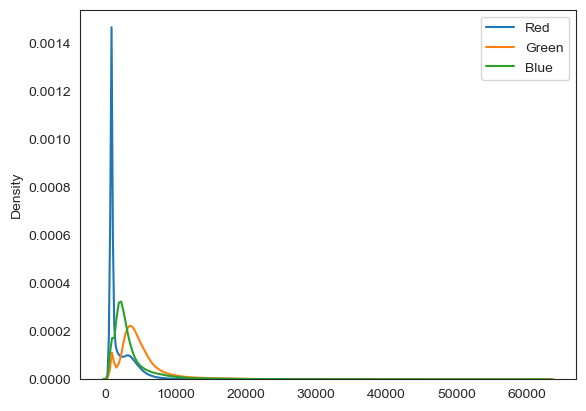

In [21]:
import seaborn as sns
get_random_images = get_random_image(1000)
sns.kdeplot(get_random_images[:, :, :, 0].ravel(), label='Red')
sns.kdeplot(get_random_images[:, :, :, 1].ravel(), label='Green')
sns.kdeplot(get_random_images[:, :, :, 2].ravel(), label='Blue')
plt.legend()
plt.show()

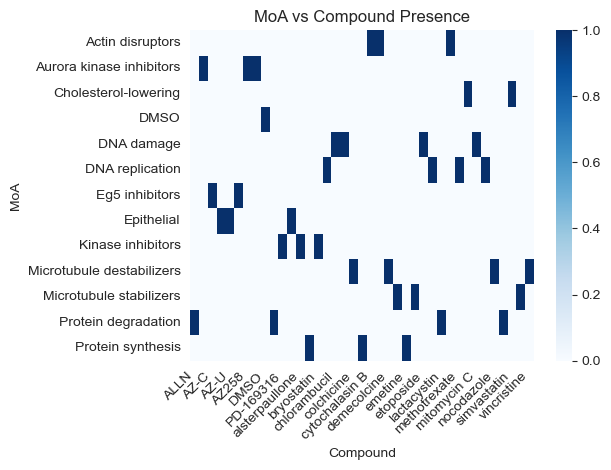

In [22]:
moa_compound_counts = meta_df.groupby(['moa', 'compound']).size().unstack(fill_value=0)
sns.heatmap(moa_compound_counts > 0, cmap='Blues')
plt.title("MoA vs Compound Presence")
plt.xlabel("Compound")
plt.ylabel("MoA")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

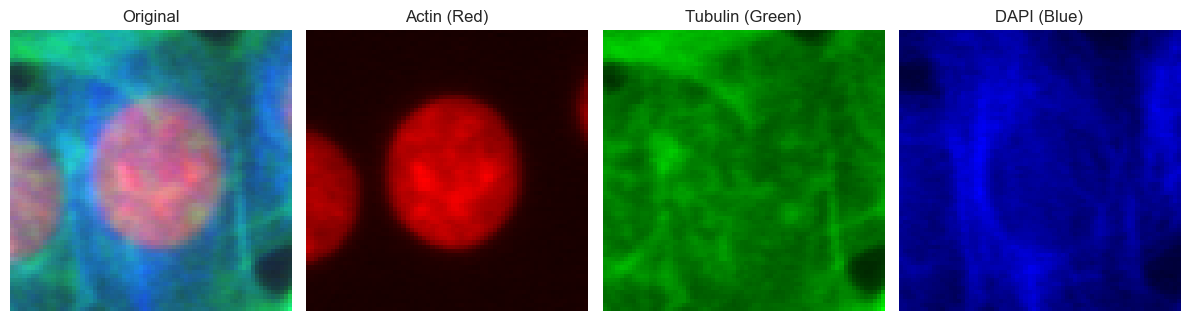

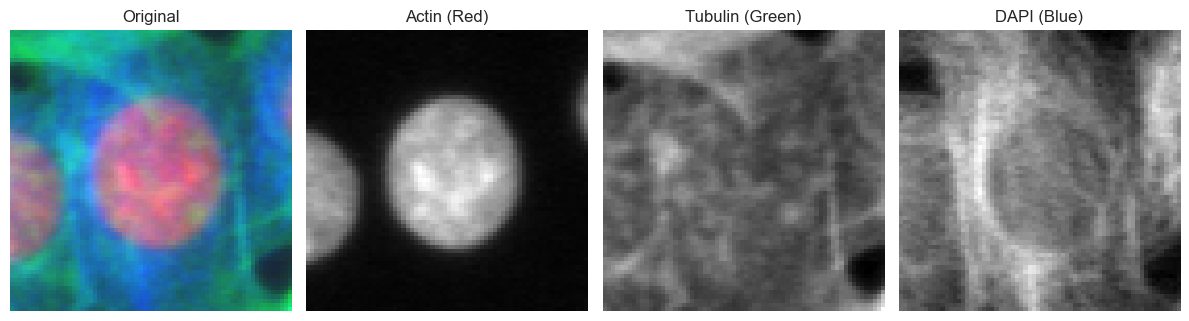

In [43]:
img = data_loader.dataset[0][0]
image = img.numpy().transpose(1, 2, 0)  # Convert to HWC format

red_channel   = np.zeros_like(image)
green_channel = np.zeros_like(image)
blue_channel  = np.zeros_like(image)

red_channel[:, :, 0] = image[:, :, 0]   # Actin (R)
green_channel[:, :, 1] = image[:, :, 1] # Tubulin (G)
blue_channel[:, :, 2] = image[:, :, 2]  # DAPI (B)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(image, vmin=0, vmax=255)
axs[0].set_title("Original")
axs[1].imshow(red_channel, vmin=0, vmax=255)
axs[1].set_title("Actin (Red)")
axs[2].imshow(green_channel, vmin=0, vmax=255)
axs[2].set_title("Tubulin (Green)")
axs[3].imshow(blue_channel, vmin=0, vmax=255)
axs[3].set_title("DAPI (Blue)")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Show as grayscale
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(image[:, :, :], cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(image[:, :, 0], cmap='gray')
axs[1].set_title("Actin (Red)")
axs[2].imshow(image[:, :, 1], cmap='gray')
axs[2].set_title("Tubulin (Green)")
axs[3].imshow(image[:, :, 2], cmap='gray')
axs[3].set_title("DAPI (Blue)")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

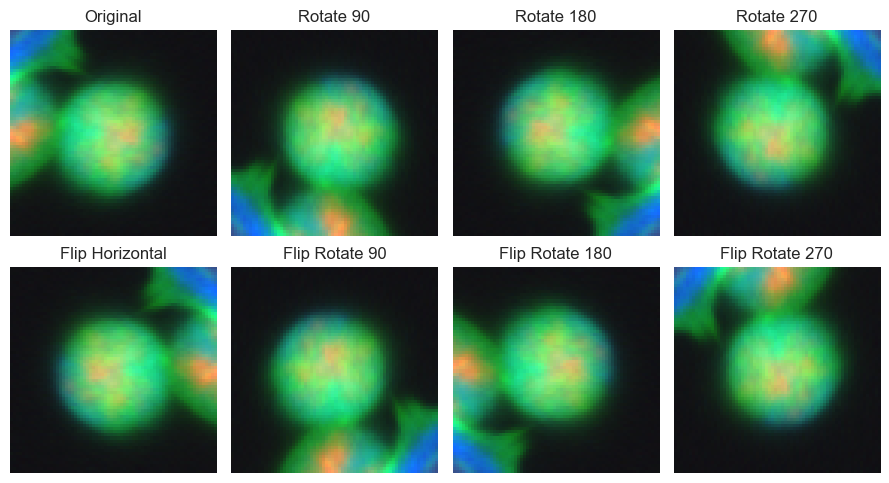

In [64]:
# Show an image and all the number of augmentations
def show_image_with_augmentations(image, augmentations):
    fig, axs = plt.subplots(2, (len(augmentations) + 1) // 2, figsize=(9, 5))
    axs = axs.flatten()

    for i, (name, aug_image) in enumerate(augmentations.items()):
        axs[i].imshow(aug_image)
        axs[i].set_title(name)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
img = get_random_image(1)[0]  # Get a random image
img_normalized = max_normalize_image(img)  # Normalize the image
# 8 different augmentations 0, 90, 180, 270 - no flip and 0, 90, 180, 270 - flip
augmentations = {
    "Original": img_normalized,
    "Rotate 90": np.rot90(img_normalized, k=1, axes=(0, 1)),
    "Rotate 180": np.rot90(img_normalized, k=2, axes=(0, 1)),
    "Rotate 270": np.rot90(img_normalized, k=3, axes=(0, 1)),
    "Flip Horizontal": np.fliplr(img_normalized),
    "Flip Rotate 90": np.fliplr(np.rot90(img_normalized, k=1, axes=(0, 1))),
    "Flip Rotate 180": np.fliplr(np.rot90(img_normalized, k=2, axes=(0, 1))),
    "Flip Rotate 270": np.fliplr(np.rot90(img_normalized, k=3, axes=(0, 1))),
}
show_image_with_augmentations(img_normalized, augmentations)

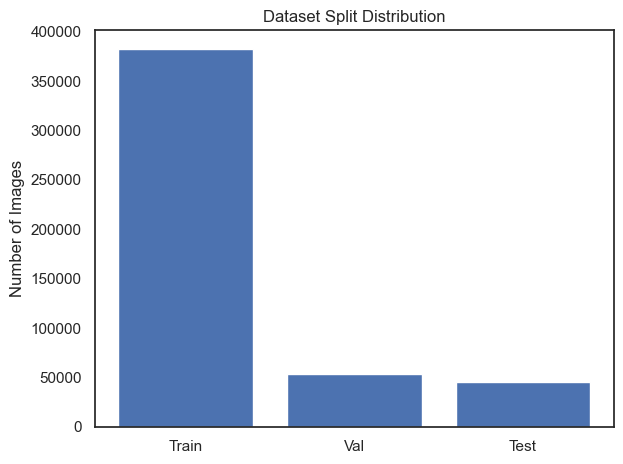

In [157]:
num_train = 382145 
num_val = 53263 
num_test = 45355 

plt.bar(["Train", "Val", "Test"], [num_train, num_val, num_test])
plt.ylabel("Number of Images")
plt.title("Dataset Split Distribution")
plt.tight_layout()
plt.show()

In [159]:
for moa in meta_df['moa'].unique():
    print(f"MoA: {moa}, Count: {len(meta_df[meta_df['moa'] == moa])}")

MoA: DMSO, Count: 274152
MoA: Protein synthesis, Count: 9715
MoA: Microtubule stabilizers, Count: 83906
MoA: Aurora kinase inhibitors, Count: 16810
MoA: DNA damage, Count: 16582
MoA: Eg5 inhibitors, Count: 12525
MoA: Epithelial, Count: 14955
MoA: Actin disruptors, Count: 7405
MoA: Microtubule destabilizers, Count: 15096
MoA: Protein degradation, Count: 6589
MoA: DNA replication, Count: 5970
MoA: Kinase inhibitors, Count: 11622
MoA: Cholesterol-lowering, Count: 5436


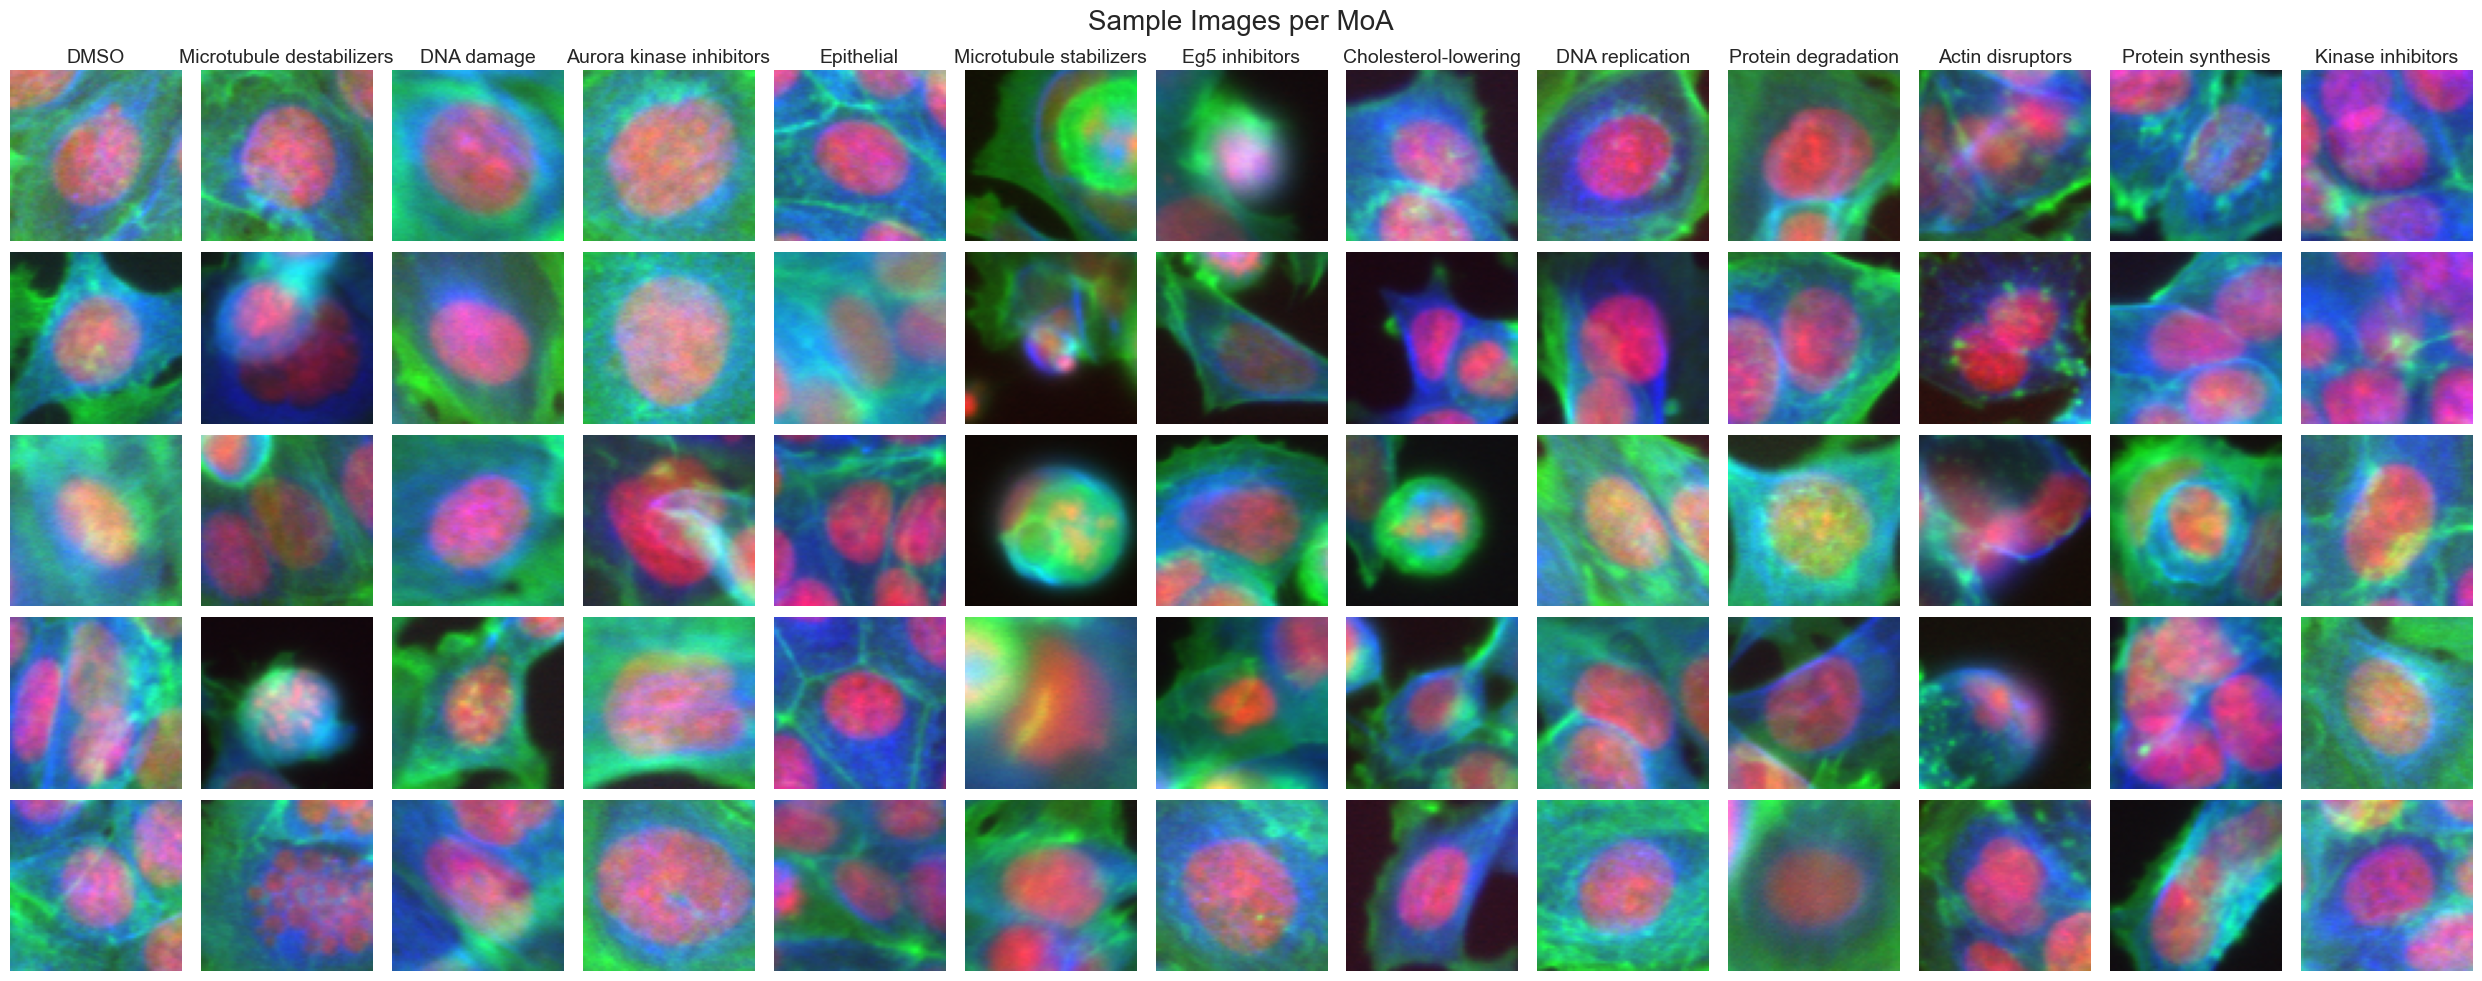

In [196]:
# plot one image per MoA
random.seed(42)  # For reproducibility
moas = meta_df['moa'].unique()
# sort moas by name length but interchange them, so long, short, long, short
moas = sorted(moas, key=lambda x: (len(x), x))
moas = [moas[i // 2] if i % 2 == 0 else moas[len(moas) - 1 - i // 2] for i in range(len(moas))]

nrows = 5
fig, axs = plt.subplots(nrows, len(moas), figsize=(25, nrows * 2))
for i, moa in enumerate(moas):
    for j in range(nrows):
        n = random.randint(0, len(meta_df[meta_df['moa'] == moa]) - 1)
        if j == 0:
            axs[j, i].set_title(moa, fontsize=14)
        sample_image = data_loader.dataset[meta_df[meta_df['moa'] == moa].index[n]][0]
        axs[j, i].imshow(sample_image.permute(1, 2, 0).numpy())
        axs[j, i].axis('off')
plt.suptitle("Sample Images per MoA", fontsize=20)
plt.tight_layout()
plt.show()